In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import matplotlib.pyplot as plt
import sys, os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

from Resources.Model import Model_v28
from Resources.Game import *


### Initializing shared game stats
##### Only once st the start

In [10]:
# stats = torch.Tensor([0, 0, 0, 0]) # batch index, white wins, black wins, draws
# torch.save(stats, '/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v28/stats')

##### Initialize Model

In [11]:
model = Model_v28()
model_saves = os.listdir('../Monte Carlo/Model Saves MC v28')
if len(model_saves) > 0:
    newest_model = max(int(i[6:-8]) for i in model_saves)
    latest_batch_index = newest_model
    model.load_state_dict(torch.load('../Monte Carlo/Model Saves MC v28/model_{}_batches'.format(newest_model)))
criterion = nn.MSELoss()

error_hist =  []
latest_batch_index = 0

# error_hist = torch.load('./error_hist MC v28')

batches:  1467
batches:  1468
batches:  1469
batches:  1470
batches:  1471
batches:  1472
batches:  1473
batches:  1474
batches:  1475
batches:  1476
batches:  1477
batches:  1478
batches:  1479
batches:  1480


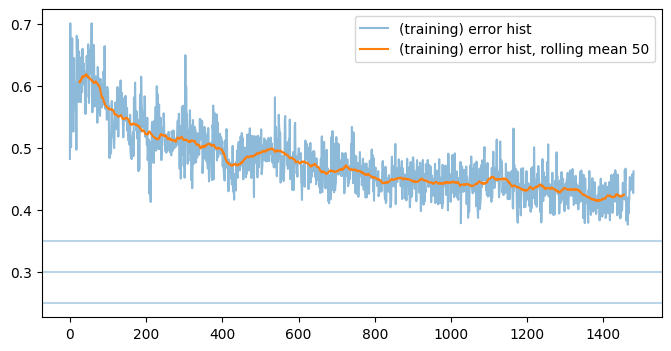

batches:  1481
batches:  1482
batches:  1483
batches:  1484
batches:  1485
batches:  1486
batches:  1487
batches:  1488
batches:  1489
batches:  1490
batches:  1491
batches:  1492
batches:  1493
batches:  1494
batches:  1495
batches:  1496
batches:  1497
batches:  1498
batches:  1499
batches:  1500


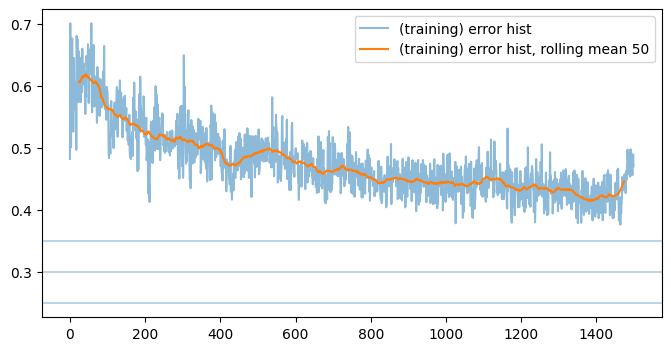

batches:  1501
batches:  1502
batches:  1503
batches:  1504


KeyboardInterrupt: 

In [13]:
lr0 = 5e-3
# a = 100 # for 1/n decay
b = - np.log(0.5) / 500 # for exp decap (half lr every 500 episodes)
n_batches = 100
n_replay = 20
weight_decay = 1e-7

av_window = 50 # window of averaging for error visual

while True:

    # wait for new data
    while True:
        try:
            with open('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v28/stats', 'rb') as f:
                stats = torch.load(f)
        except:
            time.sleep(0.05)
            continue
        if stats[0] - 1 > latest_batch_index:
            newest_batch = stats[0] - 1
            break
        else:
            time.sleep(0.05)

    newest_batch = latest_batch_index + 1

    # load all new data
    inputs = []
    labels = []
    for index in range(latest_batch_index + 1, latest_batch_index + 2):
        inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v28/inputs_{}'.format(index)))
        labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v28/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    # get error of new data (without backprop)
    out = model(inputs_tens)
    out = out.view(out.shape[0])
    loss = criterion(out, labels_tens)
    error_hist.append(loss.item())

    # load additional older data to replay
    if latest_batch_index > 5:
        # samples from exp distribution, more recent -> more likely
        decay_rate = 0.02
        prob =  np.exp(-decay_rate * np.arange(latest_batch_index)) 
        prob = prob/sum(prob)
        num_samples = n_replay
        samples = np.random.choice(np.arange(latest_batch_index, 0, -1), size=num_samples, p=prob)
        for index in samples:
            inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v28/inputs_{}'.format(index)))
            labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v28/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    # print('training batch ', newest_batch)
    t0 = time.time()

    # training step
    model.train()
    # optimizer = optim.Adam(model.parameters(), lr=lr0 * a / (a + newest_batch), weight_decay=weight_decay)
    optimizer = optim.Adam(model.parameters(), lr=lr0 * np.exp(-b * newest_batch), weight_decay=weight_decay)

    # shuffle data and make mini batches
    indices = torch.randperm(len(inputs_tens))
    inputs_tens = inputs_tens[indices]
    labels_tens = labels_tens[indices]

    batch_size = len(inputs_tens) // n_batches

    inputs_loader = inputs_tens.split(batch_size)
    labels_loader = labels_tens.split(batch_size)

    for inputs, labels in zip(inputs_loader, labels_loader):

        out = model(inputs)
        out = out.view(out.shape[0])
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # print('training done ({}s)'.format(time.time() - t0))

    if newest_batch % 1 == 0 and newest_batch > 0:
        print('batches: ', newest_batch)
    
    torch.save(error_hist, './error_hist MC v28')

    if newest_batch % 20 == 0 and newest_batch > 0:
        plt.figure(figsize=(8, 4))

        plt.axhline(0.35, xmin=0, xmax=1000, alpha=0.3)
        plt.axhline(0.30, xmin=0, xmax=1000, alpha=0.3)
        plt.axhline(0.25, xmin=0, xmax=1000, alpha=0.3)

        plt.plot(error_hist, label='(training) error hist', alpha=0.5)
        plt.plot(range(av_window//2, len(error_hist) - av_window//2), [np.mean(error_hist[i:(i+av_window)]) for i in range(len(error_hist) - av_window)], label='(training) error hist, rolling mean '+str(av_window))
        plt.legend()

        plt.show()

    if newest_batch % 5 == 0 and newest_batch > 0:
        torch.save(model.state_dict(), './Model Saves MC v28/model_{}_batches'.format(newest_batch))

    latest_batch_index = newest_batch